In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re # regular expression
import string
import nltk
from nltk.util import pr
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
data.shape

(27481, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
# verifier les valeurs manquantes:
data.isna()

,textID,text,selected_text,sentiment
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
27476,False,False,False,False
27477,False,False,False,False
27478,False,False,False,False
27479,False,False,False,False


<Axes: >

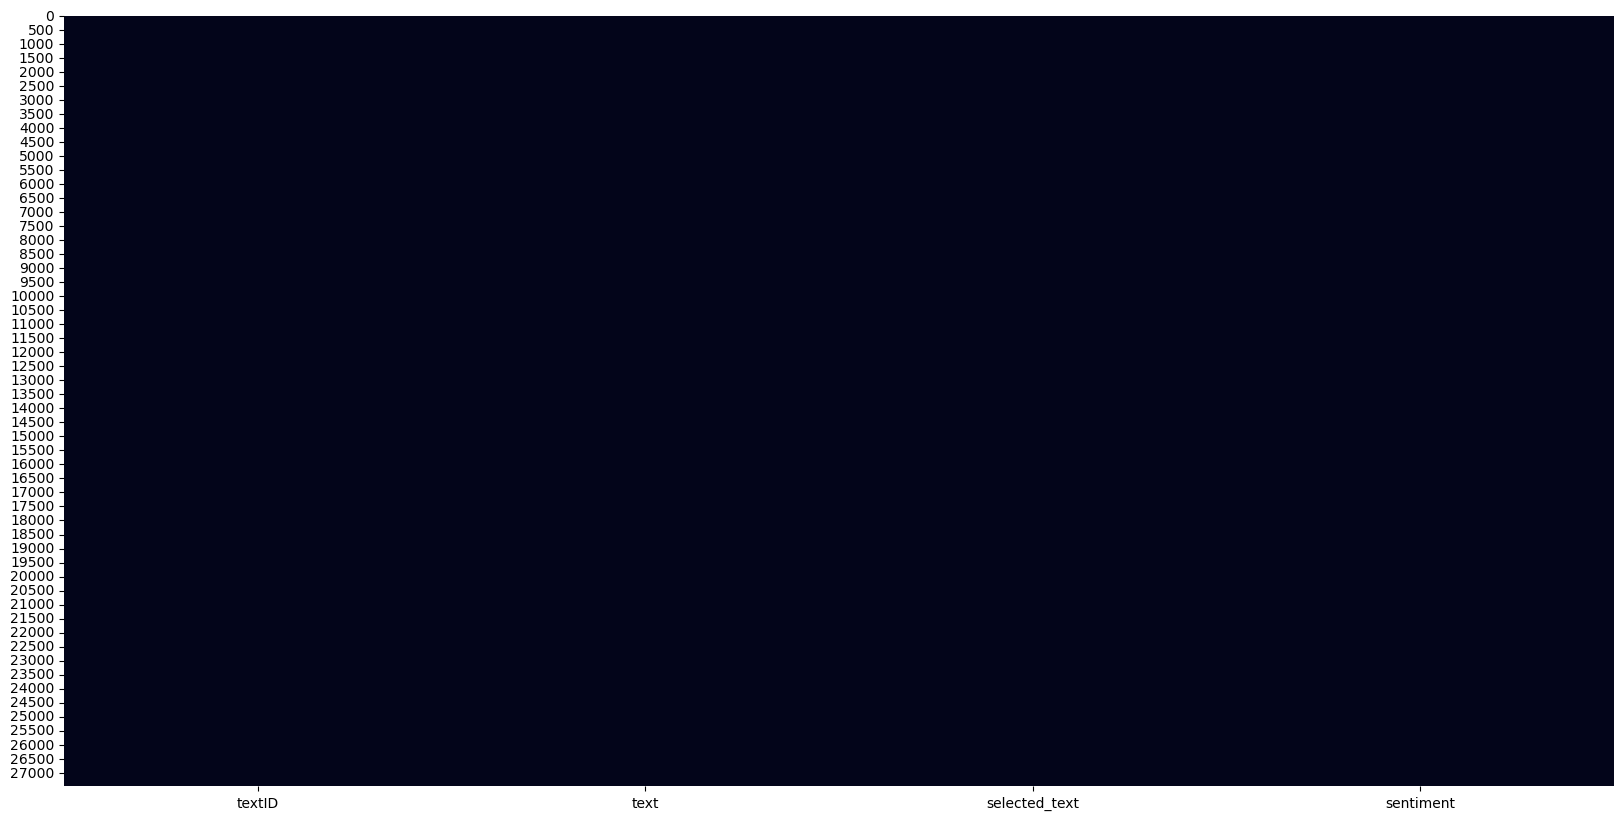

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(data.isna(), cbar=False)

In [8]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=True)

textID           0.000000
sentiment        0.000000
text             0.000036
selected_text    0.000036
dtype: float64

In [9]:
data['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [10]:
# Garder les colonnes utiles
df = data[["text", "sentiment"]].dropna()

In [11]:
df["text"] = df["text"].astype(str)

In [12]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [13]:
#Nettoyage des données
#La première chose que nous allons faire est de supprimer les mots vides. 
#Ces mots n'ont aucune valeur pour prédire le sentiment. 

In [14]:
stemmer = nltk.SnowballStemmer("english")
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fares\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    #text = [word for word in text.split(' ') if word not in stopword]
    #text = " ".join(text)
    #text = [stemmer.stem(word) for word in text.split(' ')]
    #text = " ".join(text)
    return text

In [16]:
df["text"] = df["text"].apply(clean)

In [17]:
df.head()

,text,sentiment
0,id have responded if i were going,neutral
1,sooo sad i will miss you here in san diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,sons of why couldnt they put them on the rel...,negative


In [18]:
# Encoder les labels
label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

In [19]:
df["label"] = df["sentiment"].map(label_map)

In [20]:
df.head()

,text,sentiment,label
0,id have responded if i were going,neutral,1
1,sooo sad i will miss you here in san diego,negative,0
2,my boss is bullying me,negative,0
3,what interview leave me alone,negative,0
4,sons of why couldnt they put them on the rel...,negative,0


In [21]:
# Séparation train / test
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [22]:
train_df.to_csv("df_train.csv", index=False)

In [23]:
test_df.to_csv("df_test.csv", index=False)

In [24]:
# Charger les données
dataset = load_dataset(
    "csv",
    data_files={
        "train": "df_train.csv",
        "test":  "df_test.csv"
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [25]:
#tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [26]:
def tokenize(batch):
    texts = [str(t) for t in batch["text"]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [27]:
# Appliquer la tokenisation:
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

In [28]:
# Nettoyer le dataset pour BERT:
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text", "sentiment"])
dataset.set_format("torch")

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

In [29]:
# Modèle BERT (3 classes)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

C:\Users\fares\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fares\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly

In [31]:
training_args = TrainingArguments(
    output_dir="model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01
)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
)

In [ ]:
trainer.train()
trainer.save_model("model")
tokenizer.save_pretrained("model")

C:\Users\fares\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [34]:
#evaluer le modele entrainer:
from sklearn.metrics import classification_report
from transformers import Trainer, BertForSequenceClassification

In [46]:
model = BertForSequenceClassification.from_pretrained("model")

In [47]:
trainer = Trainer(model=model)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
predictions = trainer.predict(trainer.eval_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

In [52]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["negative", "neutral", "positive"]
))

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 574ms/step - accuracy: 0.7607 - loss: 0.5915 - val_accuracy: 0.6992 - val_loss: 0.7126
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 575ms/step - accuracy: 0.7820 - loss: 0.5551 - val_accuracy: 0.7029 - val_loss: 0.7316
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 577ms/step - accuracy: 0.7953 - loss: 0.5270 - val_accuracy: 0.6919 - val_loss: 0.7194
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 81s 571ms/step - accuracy: 0.8071 - loss: 0.4992 - val_accuracy: 0.6955 - val_loss: 0.7828
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 573ms/step - accuracy: 0.8183 - loss: 0.4744 - val_accuracy: 0.7006 - val_loss: 0.8198


In [53]:
# Prédiction sur de nouveaux textes:
from transformers import pipeline

test loss, test acc: [0.8198093175888062, 0.7006224989891052]


In [51]:
classifier = pipeline(
    "sentiment-analysis",
    model="model",
    tokenizer="model"
)

KeyError: 'acc'

In [ ]:
texts = [
    "I love this product!",
    "This is okay, nothing special.",
    "Worst experience ever."
]

for t in texts:
    print(t, "→", classifier(t))

In [ ]:
# Deployer le modele avec FastAPI:
from fastapi import FastAPI
from pydantic import BaseModel

In [ ]:
# Initialisation FastAPI
app = FastAPI(
    title="Sentiment Analysis API",
    description="Analyse de sentiment avec BERT",
    version="1.0"
)

In [ ]:
# Schéma d’entrée
class TextInput(BaseModel):
    text: str

In [ ]:
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [ ]:
@app.post("/predict")
def predict_sentiment(input: TextInput):
    result = classifier(input.text)[0]
    return {
        "sentiment": label_map[result["label"]],
        "score": result["score"]
    }

In [ ]:
# Handling overfitting
# Now, we can try to do something about the overfitting. There are different options to do that.
# Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
# Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
# Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero